To configure an AutoML experiment through the AzureML SDK, you will need to configure an AutoMLConfig object. You will need to define the Task type, the Metric, the Training data, and the Compute budget you want to invest. The output of this process is a list of models from which you can select the best run and the best model associated with that run. 

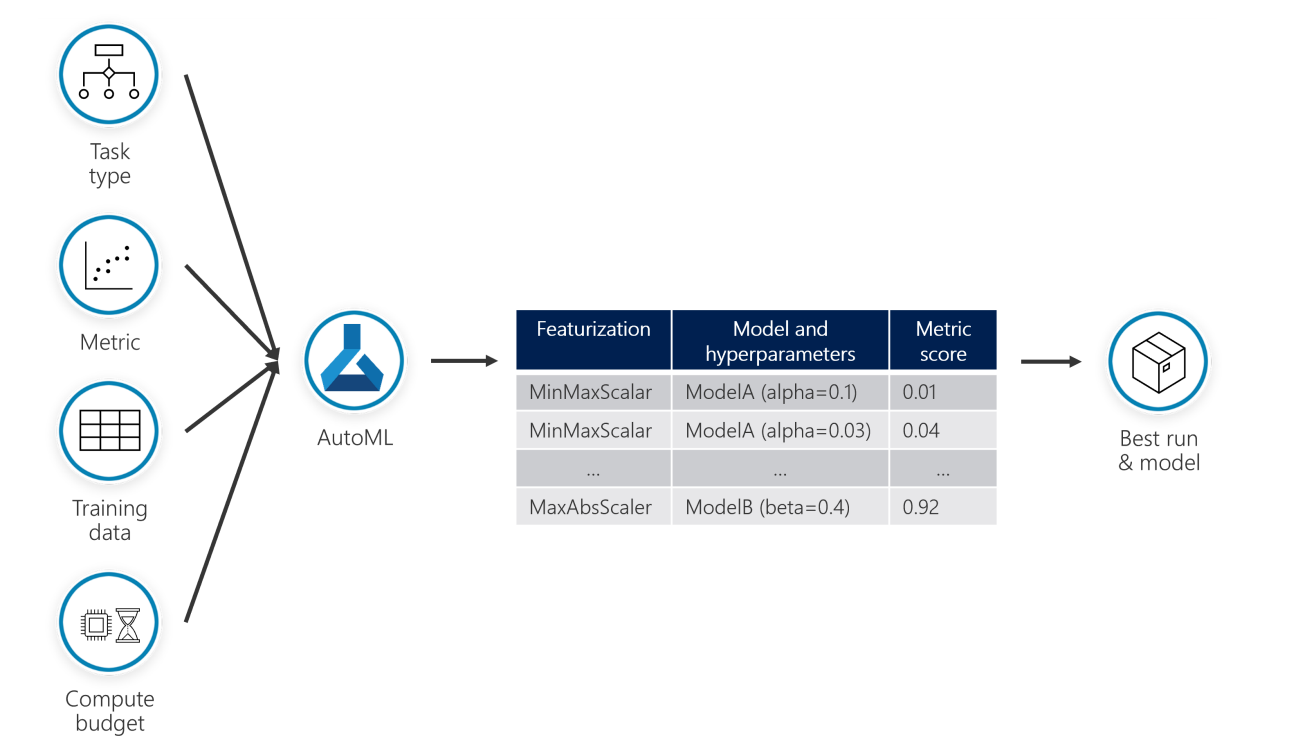

Depending on the type of problem you are trying to model, you must select the task parameter, selecting either classification, regression, or forecasting 

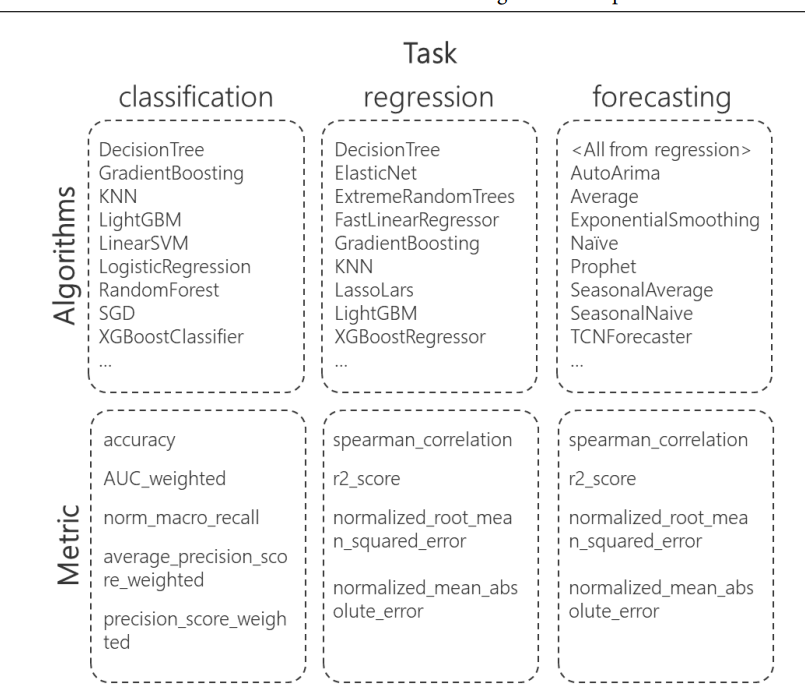

The azureml.train.automl.constants.SupportedModels package contains the classification, regression, and forecasting classes that list all supported algorithms as attributes. Since forecasting is just a more specialized version of regression, all algorithms from regression can be used. AutoML supports some additional, more specialized, forecasting algorithms, such as the very popular ARIMA technique or Facebook's Prophet algorithm. 

 

The primary_metric parameter determines the metric to be used during model training for optimization. The metrics are the same for both regression and forecasting. Classification algorithms use different metrics. 

 

Training data can be provided in the training_data parameter, either in the format of a pandas DataFrame or through the AzureML native Dataset objects. The training data is in tabular format and includes the target column. You define the name of the column you want to predict, passing the label_column_name parameter. By default, AutoML will use that dataset for both the training and validation of produced models. If the dataset is more than 20,000 rows, the dataset is split, keeping 10% for validation. If the dataset is smaller than 20,000 rows, cross-validation is used. If you want to specify how many folds to create out of training_data, you can use the n_cross_validations parameter. Another approach is to provide the validation_size parameter, which is the percentage (values 0.0 to 1.0) to hold out of the training data and use as validation. If you want to manually split the data into training and validation data, then you can assign your validation data to the validation_data parameter. 

 

Compute budget is the amount of money you are willing to spend to find the best machine learning model out of your training data. It consists of three parts:  

• The compute cluster's node type: The more capabilities your compute cluster's type has, the bigger the cost per second is when you run the AutoML job. This is a setting you configured when you created the compute cluster, and this cannot change at this point in time unless you create a new cluster.  

 

• The number of nodes to use for the AutoML job: You can define the max_ concurrent_iterations parameter to use up to the maximum number of nodes your compute cluster has. This will allow you to run parallel iterations but increases the cost. By default, this parameter is 1 and allows only a single iteration at a time.  

 

• The amount of time to search for the best model: You can either define a literal number of hours to search for the best model using the experiment_timeout_ hours parameter or you can define the experiment_exit_score parameter, which defines the score to achieve and then stop further exploration. Another way to limit your compute spending is to limit the number of different algorithms and parameter combinations to explore. By default, AutoML will explore 1,000 combinations, and you can restrict that by specifying the iterations parameter. 

In [1]:
from azureml.core import Workspace, Datastore, Dataset

In [2]:
ws=Workspace.from_config()

In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv("data/diabetes.csv")

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.shape

(768, 9)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train,X_val,y_train,y_val=train_test_split(df.drop("Outcome",axis=1),df["Outcome"],test_size=0.2)

In [10]:
X_train.shape

(614, 8)

In [11]:
y_train.shape

(614,)

In [12]:
X_val.shape

(154, 8)

In [13]:
y_val.shape

(154,)

In [14]:
train_data=pd.concat([X_train,y_train],axis=1)
train_data.to_csv("data/train_data.csv",index=False)

In [15]:
val_data=pd.concat([X_val,y_val],axis=1)
val_data.to_csv("data/val_data.csv",index=False)

In [18]:
dstore=ws.get_default_datastore()

In [19]:
dstore

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-6f0016b9-6dc5-4759-b736-d1f51ecbf40f",
  "account_name": "proddevmlws2860868256",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [20]:
dstore.upload_files(files=["data/train_data.csv"],target_path="/Data",overwrite=True,show_progress=True)

"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading data/train_data.csv
Uploaded data/train_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_f60f78b2cc994e36b2960d2b891882a8

In [21]:
dstore.upload_files(files=["data/val_data.csv"],target_path="/Data",overwrite=True,show_progress=True)

Uploading an estimated of 1 files
Uploading data/val_data.csv
Uploaded data/val_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_e7c36355cb434711a3844d2cd2fdcb21

In [23]:
file_paths=[
    (dstore,"/Data/train_data.csv"),
]

train_ds=Dataset.Tabular.from_delimited_files(path=file_paths)

In [24]:
train_ds.register(ws,name="diabetes_dataset_train",description="diabetes train data")

{
  "source": [
    "('workspaceblobstore', '/Data/train_data.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "6d344fb8-6c20-45ca-96a5-f3a5746447b6",
    "name": "diabetes_dataset_train",
    "version": 1,
    "description": "diabetes train data",
    "workspace": "Workspace.create(name='prod-dev-ml-ws', subscription_id='a8b508b6-da16-4c45-84f5-cac5c9f57513', resource_group='azure-mlops')"
  }
}

In [25]:
file_paths=[
    (dstore,"/Data/val_data.csv"),
]

val_ds=Dataset.Tabular.from_delimited_files(path=file_paths)

In [26]:
val_ds.register(ws,name="diabetes_dataset_val",description="diabetes val data")

{
  "source": [
    "('workspaceblobstore', '/Data/val_data.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "6554abad-2d4d-4ffe-b4b2-afab4230532b",
    "name": "diabetes_dataset_val",
    "version": 1,
    "description": "diabetes val data",
    "workspace": "Workspace.create(name='prod-dev-ml-ws', subscription_id='a8b508b6-da16-4c45-84f5-cac5c9f57513', resource_group='azure-mlops')"
  }
}

## Loading Datasets from the workspace

In [27]:
diabetes_train=Dataset.get_by_name(ws,name="diabetes_dataset_train")

In [29]:
diabetes_val=Dataset.get_by_name(ws,name="diabetes_dataset_val")

In [30]:
from azureml.train.automl import AutoMLConfig

In [31]:
compute_target = ws.compute_targets["cpu-sm-cluster"]

In [32]:
experiment_config = AutoMLConfig(
 task = "classification",
 primary_metric = 'AUC_weighted',
 training_data = diabetes_train,
 label_column_name = "Outcome",
 validation_data = diabetes_val,
 compute_target = compute_target,
 experiment_timeout_hours = 0.25,
 iterations = 100
)

In [33]:
from azureml.core.experiment import Experiment
my_experiment = Experiment(ws, 'myautoml-experiment')
run = my_experiment.submit(experiment_config,
 show_output=True)

Submitting remote run.
No run_configuration provided, running on cpu-sm-cluster with default configuration
Running on remote compute: cpu-sm-cluster


Experiment,Id,Type,Status,Details Page,Docs Page
myautoml-experiment,AutoML_a2164b93-c39f-4476-aa40-d6f4788d8724,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

***********************************************************************

In [34]:
best_run, best_model = run.get_output()

In [35]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
myautoml-experiment,AutoML_a2164b93-c39f-4476-aa40-d6f4788d8724_21,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In every automated machine learning experiment, your data is automatically scaled
or normalized to help algorithms perform well. This data transformation is becoming part
of the trained model. This means that your data is passing through a data transformer
first, and then the model is being trained with new feature names that are not directly
visible to you

To review the actual steps that are embedded
within the AutoML model, you can use the steps attribute of the produced model

In [37]:
best_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=False, is_onnx_compatible=False, task='classification')),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=array([0, 1]), estimators=[('17', Pipeline(memory=None, steps=[('standardscalerwrapper', StandardScalerWrapper(copy=True, with_mean=False, with_std=True)), ('extratreesclassifier', ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced', criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=0.01, min_samples_split=0.056842105263157895, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False))], verbose=False)), ('15', Pipeline(memory=None,

The first step is named datatransformer and contains the imputers used for
our diabetes dataset. This step is named datatransformer for both regression and
classification tasks. For forecasting tasks, this step is named timeseriestransformer,
and it contains additional date-based transformations. To get a list of transformations and
the names of engineered features, you can use the following code snippet

In [40]:
print(best_model.named_steps['datatransformer'] \
 .get_featurization_summary())


[{'RawFeatureName': 'Pregnancies', 'TypeDetected': 'Categorical', 'Dropped': 'No', 'EngineeredFeatureCount': 17, 'Transformations': ['StringCast-CharGramCountVectorizer']}, {'RawFeatureName': 'Glucose', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1, 'Transformations': ['MeanImputer']}, {'RawFeatureName': 'BloodPressure', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1, 'Transformations': ['MeanImputer']}, {'RawFeatureName': 'SkinThickness', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1, 'Transformations': ['MeanImputer']}, {'RawFeatureName': 'Insulin', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1, 'Transformations': ['MeanImputer']}, {'RawFeatureName': 'BMI', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1, 'Transformations': ['MeanImputer']}, {'RawFeatureName': 'DiabetesPedigreeFunction', 'TypeDetected': 'Numeric', 'Dropped': 'No', 'EngineeredFeatureCount': 1,

In [41]:
feature_names=best_model.named_steps['datatransformer'] \
 .get_engineered_feature_names()
print("Engineered feature names:")
print(feature_names)

Engineered feature names:
['Pregnancies_CharGramCountVectorizer_0', 'Pregnancies_CharGramCountVectorizer_1', 'Pregnancies_CharGramCountVectorizer_10', 'Pregnancies_CharGramCountVectorizer_11', 'Pregnancies_CharGramCountVectorizer_12', 'Pregnancies_CharGramCountVectorizer_13', 'Pregnancies_CharGramCountVectorizer_14', 'Pregnancies_CharGramCountVectorizer_15', 'Pregnancies_CharGramCountVectorizer_17', 'Pregnancies_CharGramCountVectorizer_2', 'Pregnancies_CharGramCountVectorizer_3', 'Pregnancies_CharGramCountVectorizer_4', 'Pregnancies_CharGramCountVectorizer_5', 'Pregnancies_CharGramCountVectorizer_6', 'Pregnancies_CharGramCountVectorizer_7', 'Pregnancies_CharGramCountVectorizer_8', 'Pregnancies_CharGramCountVectorizer_9', 'Glucose_MeanImputer', 'BloodPressure_MeanImputer', 'SkinThickness_MeanImputer', 'Insulin_MeanImputer', 'BMI_MeanImputer', 'DiabetesPedigreeFunction_MeanImputer', 'Age_MeanImputer']
